# Conversational Data Explorer

## Project Requirements
- Python 3.8+
- LangChain & LangGraph
- OpenAI API key
- Pandas & Matplotlib

In [1]:

# %pip install -q --upgrade langchain langchain-openai langgraph pandas matplotlib

## Package Installation & Setup 

Initial setup including:
- Required package installation
- Environment configuration
- Core library imports
- OpenAI API key setup

This establishes the foundation for our multi-turn conversational agent.

In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional, Type, TypedDict

from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain.tools import BaseTool
from langchain.agents import AgentExecutor, create_openai_tools_agent

from langgraph.graph import StateGraph, END


# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = "OpenAI-api-key"



c:\Users\Aditya Kumar\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## State Management 

`AgentState` class definition:
- Type-safe message history tracking
- Uses TypedDict for clear interface
- Maintains conversation context
- Essential for multi-turn functionality

In [3]:

class AgentState(TypedDict):
    messages: List[BaseMessage]


## LoadDataTool Implementation 

Implements data loading functionality:
- Type-safe argument handling with Pydantic
- Clear error messages and handling
- DataFrame management
- Async support for future scalability

This tool forms the foundation for data analysis capabilities.

In [4]:

# --- LoadDataTool ---
class LoadDataArgs(BaseModel):
    file_path: str = Field(..., description="Path to the CSV file to load")

class LoadDataTool(BaseTool):
    name: str = "load_data"
    description: str = "Load a CSV file into memory for analysis"
    args_schema: Type[LoadDataArgs] = LoadDataArgs
    df: Optional[pd.DataFrame] = None

    def _run(self, file_path: str) -> str:
        try:
            self.df = pd.read_csv(file_path)
            return f"Loaded {len(self.df)} rows x {len(self.df.columns)} columns from {file_path}."
        except Exception as e:
            return f"Failed to load CSV: {e}"
    
    async def _arun(self, file_path: str) -> str:
        return self._run(file_path)


## AnalyzeDataTool Implementation 

Data analysis capabilities:
- Multiple analysis methods (head, describe, value_counts)
- Smart query parsing and execution
- Dependency management with LoadDataTool
- Error handling and feedback
- Clear response formatting

In [5]:

# --- AnalyzeDataTool ---
class AnalyzeDataArgs(BaseModel):
    query: str = Field(..., description="Simple analysis instruction, e.g., 'head(5)' or 'describe()'")

class AnalyzeDataTool(BaseTool):
    name: str = "analyze_data"
    description: str = "Analyze the loaded DataFrame: head(n), describe(), columns, value_counts(col), top_by(col, n)"
    args_schema: Type[AnalyzeDataArgs] = AnalyzeDataArgs

    load_tool: Optional[LoadDataTool] = None

    @classmethod
    def from_load_tool(cls, load_tool: "LoadDataTool") -> "AnalyzeDataTool":
        tool = cls()
        tool.load_tool = load_tool
        return tool

    def _run(self, query: str) -> str:
        if self.load_tool is None or self.load_tool.df is None:
            return "No data loaded. Use load_data first."
        df = self.load_tool.df
        try:
            q = query.strip().lower()
            if q.startswith("head(") and q.endswith(")"):
                n = int(q[len("head("):-1])
                return df.head(n).to_string(index=False)
            if q == "head":
                return df.head(5).to_string(index=False)
            if q in ("describe()", "describe"):
                return df.describe(include='all').to_string()
            if q == "columns":
                return ", ".join(map(str, df.columns.tolist()))
            if q.startswith("value_counts(") and q.endswith(")"):
                col = q[len("value_counts("):-1].strip()
                if col not in df.columns:
                    return f"Column '{col}' not found."
                return df[col].value_counts().to_string()
            if q.startswith("top_by(") and q.endswith(")"):
                inside = q[len("top_by("):-1]
                parts = [p.strip() for p in inside.split(",")]
                if len(parts) != 2:
                    return "Use: top_by(col, n)"
                col, n = parts[0], int(parts[1])
                if col not in df.columns:
                    return f"Column '{col}' not found."
                return df.nlargest(n, col).to_string(index=False)
            return "Unknown query. Try: head, head(n), describe(), columns, value_counts(col), top_by(col, n)."
        except Exception as e:
            return f"Analyze error: {e}"
    
    async def _arun(self, query: str) -> str:
        return self._run(query)


## PlotDataTool Implementation 

Visualization capabilities:
- Multiple plot types (line, bar, scatter)
- Flexible parameter handling
- Error checking for columns
- Professional plot formatting
- Interactive display

This tool adds creative visualization options to enhance data exploration.

In [6]:

# --- PlotDataTool ---
class PlotDataArgs(BaseModel):
    command: str = Field(..., description="Format: 'plot_type, x_col, y_col, title' where plot_type in {line, bar, scatter}")

class PlotDataTool(BaseTool):
    name: str = "plot_data"
    description: str = "Create a matplotlib chart from the loaded DataFrame"
    args_schema: Type[PlotDataArgs] = PlotDataArgs

    load_tool: Optional[LoadDataTool] = None

    @classmethod
    def from_load_tool(cls, load_tool: "LoadDataTool") -> "PlotDataTool":
        tool = cls()
        tool.load_tool = load_tool
        return tool

    def _run(self, command: str) -> str:
        if self.load_tool is None or self.load_tool.df is None:
            return "No data loaded. Use load_data first."
        df = self.load_tool.df
        parts = [p.strip() for p in command.split(",")]
        if len(parts) != 4:
            return "Use: 'plot_type, x_col, y_col, title'"
        plot_type, x, y, title = parts
        if x not in df.columns or y not in df.columns:
            return f"Columns '{x}' or '{y}' not found. Available: {', '.join(df.columns)}"
        try:
            plt.figure()
            if plot_type == "line":
                plt.plot(df[x], df[y])
            elif plot_type == "bar":
                plt.bar(df[x], df[y])
            elif plot_type == "scatter":
                plt.scatter(df[x], df[y])
            else:
                return "plot_type must be one of: line, bar, scatter"
            plt.xlabel(x)
            plt.ylabel(y)
            plt.title(title)
            plt.show()
            return "Plot created."
        except Exception as e:
            return f"Plot error: {e}"
    
    async def _arun(self, command: str) -> str:
        return self._run(command)


## Agent Configuration 

Setting up the conversational agent:
- Tool instantiation and linking
- LLM configuration (OpenAI GPT-4)
- Prompt template design
- Agent executor setup with error handling

This section integrates all components into a cohesive system.

In [7]:

# Instantiate tools
load_tool = LoadDataTool()
analyze_tool = AnalyzeDataTool.from_load_tool(load_tool)
plot_tool = PlotDataTool.from_load_tool(load_tool)
tools = [load_tool, analyze_tool, plot_tool]

# LLM & Prompt with placeholders
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful data analysis assistant. Use tools when needed. Be concise and actionable."),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
    MessagesPlaceholder("agent_scratchpad"),
])

agent = create_openai_tools_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)
print("Agent initialized")


Agent initialized


## Conversation Flow Implementation

Core conversation management:
- Message processing logic
- State updates and maintenance
- Tool selection and execution
- Response formatting
- Graph-based workflow

This implements the main reasoning flow of the agent.

In [8]:

def agent_node(state: AgentState) -> AgentState:
    msgs = state["messages"]
    if not msgs:
        return state
    last = msgs[-1]
    if not isinstance(last, HumanMessage):
        last = HumanMessage(content=getattr(last, "content", str(last)))
    chat_history = msgs[:-1]
    result = agent_executor.invoke({"input": last.content, "chat_history": chat_history})
    output_text = result.get("output") or result.get("output_text") or str(result)
    state["messages"].append(AIMessage(content=output_text))
    return state

graph = StateGraph(AgentState)
graph.add_node("agent", agent_node)
graph.set_entry_point("agent")
graph.add_edge("agent", END)
app = graph.compile()
print("LangGraph compiled")


LangGraph compiled


In [9]:

def run_turn(user_text: str, history: Optional[List[BaseMessage]] = None) -> List[BaseMessage]:
    if history is None:
        history = []
    state: AgentState = {"messages": history + [HumanMessage(content=user_text)]}
    out = app.invoke(state)
    return out["messages"]


## Demo Data Setup

Sample dataset creation:
- Simple time-series data
- Revenue and units tracking
- Monthly granularity
- Realistic values

This provides a practical example for testing the agent's capabilities.

In [10]:

#demo CSV
# toy_path = "sample.csv"
# toy_df = pd.DataFrame({
#     "month": ["Jan","Feb","Mar","Apr","May","Jun"],
#     "revenue": [1200, 1500, 1600, 900, 1800, 2100],
#     "units": [120, 140, 150, 90, 175, 195]
# })
# toy_df.to_csv(toy_path, index=False)
# toy_df.head()


## Turn Execution

Single turn handling logic:
- Message history management
- State initialization
- Graph invocation
- Response processing

This function executes individual conversation turns while maintaining context.

## Interactive Chat Loop 

Main interaction loop:
- User input handling
- Message formatting
- Error management
- Clean exit options
- History tracking

This provides the user interface for the conversational agent.

Chat ready. Type your message. Type 'quit' to stop.
Human: Load the dataset sample_sales.csv
Assistant: The dataset `sample_sales.csv` has been successfully loaded, containing 10 rows and 5 columns. What would you like to do next?

Human: Analyze the dataset
Assistant: ### Dataset Analysis

#### Head (First 5 Rows)
```
      date    product    category  quantity  revenue
0  2024-01-01    Laptop  Electronics         5     5000
1  2024-01-01      Phone  Electronics        10     5000
2  2024-01-02     Table   Furniture         3     1500
3  2024-01-02     Chair   Furniture         8     1600
4  2024-01-03    Laptop  Electronics         7     7000
```

#### Descriptive Statistics
- **Count**: 10 entries for each column
- **Unique Products**: 5
- **Categories**: 2 (Electronics, Furniture)
- **Quantity**: 
  - Mean: 7.3
  - Std Dev: 3.59
  - Min: 3
  - Max: 15
- **Revenue**: 
  - Mean: 4010
  - Std Dev: 2345.42
  - Min: 1500
  - Max: 7500

#### Columns
- `date`
- `product`
- `category`
- `q

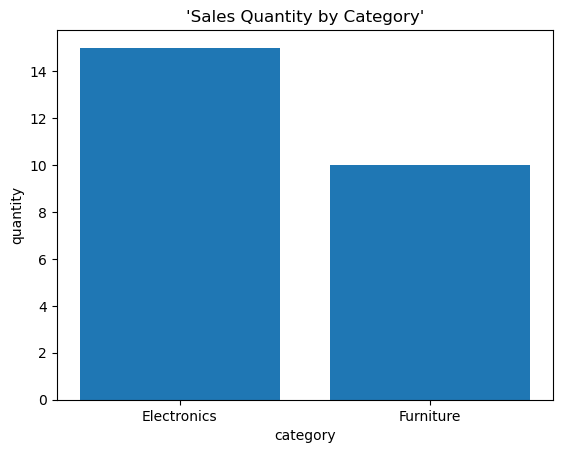

Assistant: A bar graph titled "Sales Quantity by Category" has been created, illustrating the sales quantity for each category. This visual representation helps in understanding the distribution of sales between Electronics and Furniture. 

If you need further analysis or another type of visualization, let me know!

Human: more visualization with different views


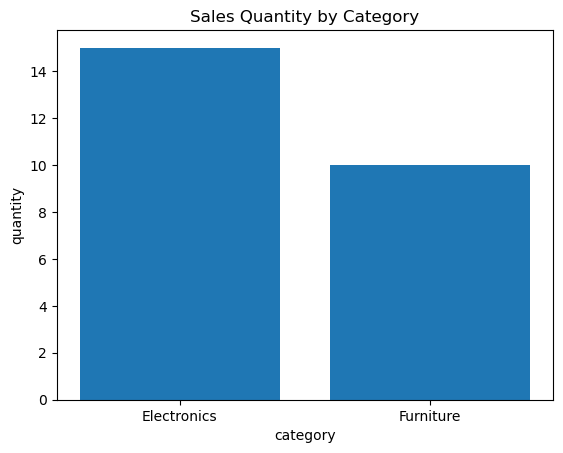

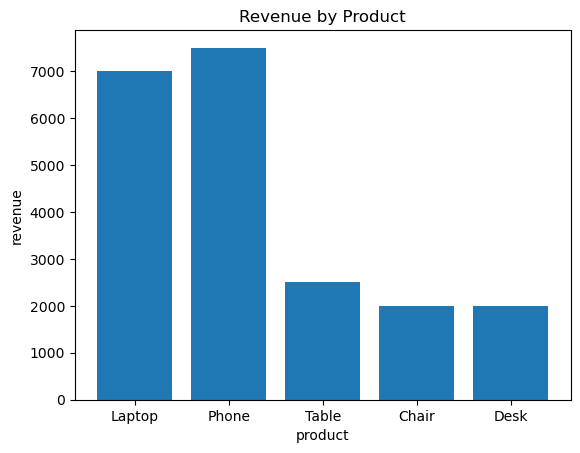

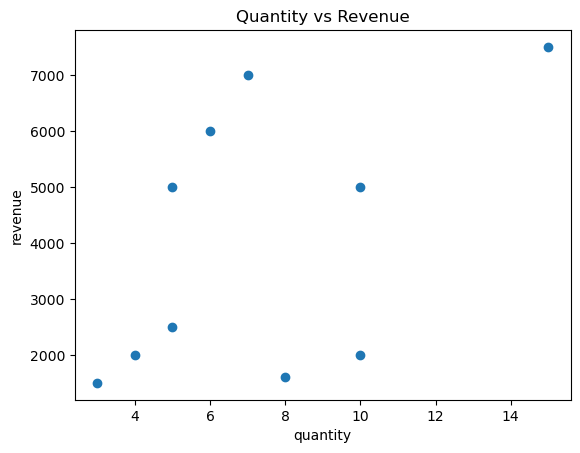

Assistant: I have created three additional visualizations:

1. **Sales Quantity by Category**: A bar graph showing the quantity sold for each category.
2. **Revenue by Product**: A bar graph illustrating the revenue generated by each product.
3. **Quantity vs Revenue**: A scatter plot displaying the relationship between quantity sold and revenue.

These visualizations provide a comprehensive view of the dataset. If you need further insights or additional visualizations, feel free to ask!

Human: what's the revenue generated by laptop?
Assistant: The total revenue generated by laptops is calculated as follows:

- From the dataset:
  - 7 units sold on 2024-01-03 generated $7000.
  - 6 units sold on 2024-01-05 generated $6000.

### Total Revenue from Laptops:
- **Total Revenue**: $7000 + $6000 = **$13,000**

If you need any more information or further analysis, let me know!

Human: what else I can analyze from the dataset?
Assistant: Here are several analyses you can perform on the datase

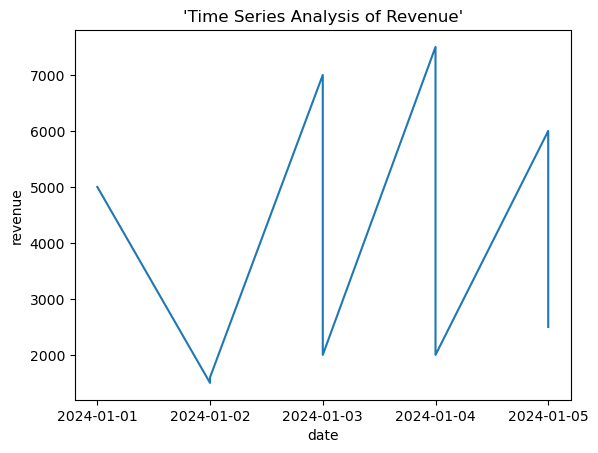

Assistant: The time series analysis of revenue has been plotted, showing how revenue changes over time. This visualization helps identify trends and patterns in sales performance.

If you need further analysis or additional insights, feel free to ask!

Human: Quit
Exiting chat.


In [11]:

# Continuous chat loop stop with 'quit' / 'exit' / 'q'
def chat_loop(quit_words=("quit","exit","q")):
    print("Chat ready. Type your message. Type 'quit' to stop.")
    history: List[BaseMessage] = []
    while True:
        try:
            user = input("You: ").strip()
            print("Human: " + user )
        except (EOFError, KeyboardInterrupt):
            print("\nExiting chat.")
            break
        if user.lower() in quit_words:
            print("Exiting chat.")
            break
        history = run_turn(user, history)
        # Print last assistant message
        reply = history[-1].content if history and hasattr(history[-1], "content") else "(no reply)"
        print(f"Assistant: {reply}\n")

# Start the conversation
chat_loop()
